In [ ]:
from yahoo_fin.stock_info import get_data
import yahoo_fin.stock_info as si
import pandas as pd 
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

In [ ]:
# fill nan value with average
def fillNan(m):

    rows=len(m) 
    columns=m.shape[1]
 
    for j in range(0,columns):
        if m.columns[j] == 'date':
            continue
        m[m.columns[j]] = pd.to_numeric(m[m.columns[j]])
        sum1=0.0
        count=0.0
        for i in range(0,rows):
            if not (pd.isna(m[m.columns[j]][i])):
                sum1+=float(m[m.columns[j]][i])
                count+=1
        # in case all nan value 
        avg=sum1/max(count,1)
        for i in range(0,rows):
            if pd.isna(m[m.columns[j]][i]) or (float(m[m.columns[j]][i])==0):
                m[m.columns[j]][i]=avg
    return m

In [ ]:
#use mad delete extreme value
def MAD(dataset, n):
    median = np.median(dataset)  # 中位数
    deviations = abs(dataset - median)
    mad = np.median(deviations)
 
    remove_idx = np.where(abs(dataset - median) >  n * mad)
    new_data = np.delete(dataset, remove_idx)
 
    return new_data
# normalization data
def Normalization(x):
    return [(float(i)-min(x))/float(max(x)-min(x)) for i in x]

In [ ]:
def clean(ticker,url):
    #get df of stock
    df = pd.read_csv(url, index_col=0)
    
    stock_data = get_data(ticker, start_date="01/01/2010", end_date="07/10/2021", index_as_date = True, interval="1mo")
    stock_data.index=stock_data.index.to_period("M")
    #add monthly log return column
    stock_data['log_return'] = np.log(stock_data['close']).diff()
    
    
    df=df.drop(['open','high','low','close','adjclose','volume','ticker'],axis=1)
    df.index = pd.to_datetime(df.index)
    df.index = df.index.to_period('M')
    df = df.join(stock_data)
    
    #drop the columns when all rows of this columns are all nan
    df=df.dropna(how='all',axis=1)
    df = df.replace(',','', regex=True)
    df.columns = df.columns.str.replace('\t', '')
    df=df.drop(['open','close','high','low','ticker'],axis=1)
    df = fillNan(df)
    df['adjclose'] = MAD(df['adjclose'],n=5)
    df['adjclose'] = Normalization(df['adjclose'])
    if 'Cushing OK WTI Spot Price FOB Dollars per Barrel' in df.columns:
        df=df.rename({'Cushing OK WTI Spot Price FOB Dollars per Barrel' : 'OilPrice'}, axis=1)
    return df

In [ ]:
# get dataframe after cleaning 
data=clean('aal', 'https://raw.githubusercontent.com/GaoleL/Data_project/main/Data/aal_macro.csv')
data.head()

<ipython-input-86-98646b20a799>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m[m.columns[j]][i]=avg


OperatingRevenue  CostOfRevenue  GrossProfit  OperatingExpense  \
date                                                                      
2021-03        3494000000     6164000000  -2156000000         867000000   
2020-12        3475000000     5883000000  -1855000000         678000000   
2020-09        2747000000     5610000000  -2437000000         729000000   
2020-06        1238000000     4946000000  -3324000000         588000000   
2020-03        7828000000     8450000000     65000000        1715000000   

         SellingGeneralAndAdministration  GeneralAndAdministrativeExpense  \
date                                                                        
2021-03                      151000000.0                     1.832364e+09   
2020-12                       95000000.0                     1.832364e+09   
2020-09                       70000000.0                     1.832364e+09   
2020-06                       43000000.0                     1.832364e+09   
2020-03                      305000000.0                     1.832364e+09   

         SalariesAndWages  RentAndLandingFees    OtherGandA  \
date                                                          
2021-03      1.749364e+09        4.992727e+08 -4.162727e+08   
2020-12      1.749364e+09        4.992727e+08 -4.162727e+08   
2020-09      1.749364e+09        4.992727e+08 -4.162727e+08   
2020-06      1.749364e+09        4.992727e+08 -4.162727e+08   
2020-03      1.749364e+09        4.992727e+08 -4.162727e+08   

         SellingAndMarketingExpense  ...  EnterprisesValueRevenueRatio  \
date                                 ...                                 
2021-03                 151000000.0  ...                        12.347   
2020-12                  95000000.0  ...                        10.606   
2020-09                  70000000.0  ...                        11.499   
2020-06                  43000000.0  ...                        22.900   
2020-03                 305000000.0  ...                         4.084   

         EnterprisesValueEBITDARatio  OilPrice        GDP  Inflation  \
date                                                                   
2021-03                      -41.170     59.19  22061.503   1.900000   
2020-12                      -17.559     48.35  21494.731   1.266667   
2020-09                      -13.244     40.05  21170.252   1.233333   
2020-06                      -15.444     39.27  19520.114   0.333333   
2020-03                      -13.207     20.51  21561.139   2.100000   

         ExchangeRate  UnemploymentRate  adjclose      volume  log_return  
date                                                                       
2021-03      6.484221          6.166667  0.415343  1077197000    0.132217  
2020-12      6.622164          6.766667  0.238738  1859647300    0.109809  
2020-09      6.918338          8.800000  0.163144  1199512900   -0.060002  
2020-06      7.085335         13.066667  0.180087  3103539000    0.218944  
2020-03      6.982367          3.800000  0.160971  1304401000   -0.446451  

[5 rows x 68 columns]

In [ ]:
#Variance inflation factor (VIF)
def vif(df, col_i):
    cols = list(df.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1. / (1. - r2)


In [ ]:
# factors maybe change based on different stocks, eg. some stocks has surgar price data, some are not
test_data = data[['OperatingRevenue', 'CostOfRevenue', 'OperatingExpense',
'NetNonOperatingInterestIncomeExpense', 
        'TaxProvision','NetIncome',
       'BasicEPS',  'BasicAverageShares', 
       'TotalOperatingIncomeAsReported', 'RentExpenseSupplemental',
       'TotalExpenses', 
       'NormalizedIncome', 'InterestIncome', 'InterestExpense',
       'NetInterestIncome', 'EBIT',  
       'TotalUnusualItems',
        'TaxEffectOfUnusualItems',
        'volume', 'MarketCap',
       'EnterpriseValue', 'PeRatio', 'PegRatio', 'PsRatio',
       'PbRatio'
       
    ]]

efficient_col=[]
for i in test_data.columns:
    print(i, '\t', vif(test_data, col_i=i))
    if float(vif(test_data,col_i=i))<20:
        efficient_col.append(i)

# check if there is an zero 
# test_data.all(axis='columns')
test_data.isnull().sum()

OperatingRevenue 	 187.98803946594134
CostOfRevenue 	 inf
OperatingExpense 	 inf
NetNonOperatingInterestIncomeExpense 	 inf
TaxProvision 	 inf
NetIncome 	 inf


<ipython-input-90-6216a0607cca>:8: RuntimeWarning: divide by zero encountered in double_scalars
  return 1. / (1. - r2)


BasicEPS 	 13.532651075755203
BasicAverageShares 	 34.27874879027565
TotalOperatingIncomeAsReported 	 96.57419906090654
RentExpenseSupplemental 	 112.40182216827131
TotalExpenses 	 inf
NormalizedIncome 	 inf
InterestIncome 	 inf
InterestExpense 	 inf
NetInterestIncome 	 inf
EBIT 	 inf
TotalUnusualItems 	 inf
TaxEffectOfUnusualItems 	 inf
volume 	 8.24376616006573
MarketCap 	 109.59310038786087
EnterpriseValue 	 80.812674481179
PeRatio 	 6.727750911199248
PegRatio 	 1.2600420136315038
PsRatio 	 29.82668420304074
PbRatio 	 1.5826638129601864


OperatingRevenue                        0
CostOfRevenue                           0
OperatingExpense                        0
NetNonOperatingInterestIncomeExpense    0
TaxProvision                            0
NetIncome                               0
BasicEPS                                0
BasicAverageShares                      0
TotalOperatingIncomeAsReported          0
RentExpenseSupplemental                 0
TotalExpenses                           0
NormalizedIncome                        0
InterestIncome                          0
InterestExpense                         0
NetInterestIncome                       0
EBIT                                    0
TotalUnusualItems                       0
TaxEffectOfUnusualItems                 0
volume                                  0
MarketCap                               0
EnterpriseValue                         0
PeRatio                                 0
PegRatio                                0
PsRatio                           

In [ ]:
# Regression with adjclose price
X = test_data # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = data['adjclose']
X = sm.add_constant(X)
est = sm.OLS(Y, X.astype(float)).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     89.63
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           2.58e-17
Time:                        16:26:23   Log-Likelihood:                 85.985
No. Observations:                  45   AIC:                            -128.0
Df Residuals:                      23   BIC:                            -88.22
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.1218      0.168      0.725      0.476      -0.226       0.469
OperatingRevenue                     -1.264e-10   4.13e-11     -3.060      0.006   -2.12e-10    -4.1e-11
CostOfRevenue                         3.282e-08   3.64e-07      0.090      0.929   -7.21e-07    7.87e-07
OperatingExpense                      3.286e-08   3.64e-07      0.090      0.929   -7.21e-07    7.87e-07
NetNonOperatingInterestIncomeExpense -2.005e-08   1.59e-07     -0.126      0.901   -3.49e-07    3.09e-07
TaxProvision                          4.006e-09   3.88e-08      0.103      0.919   -7.63e-08    8.43e-08
NetIncome                            -2.018e-09   4.47e-08     -0.045      0.964   -9.44e-08    9.04e-08
BasicEPS                                 0.0355      0.009      4.130      0.000       0.018       0.053
BasicAverageShares                   -9.343e-10    2.1e-10     -4.452      0.000   -1.37e-09      -5e-10
TotalOperatingIncomeAsReported        8.045e-11   6.47e-11      1.244      0.226   -5.33e-11    2.14e-10
RentExpenseSupplemental              -3.576e-10   3.98e-10     -0.900      0.378   -1.18e-09    4.65e-10
TotalExpenses                        -3.269e-08   3.64e-07     -0.090      0.929   -7.87e-07    7.21e-07
NormalizedIncome                      5.994e-09   8.34e-08      0.072      0.943   -1.67e-07    1.79e-07
InterestIncome                         1.69e-08   9.95e-08      0.170      0.867   -1.89e-07    2.23e-07
InterestExpense                      -5.435e-09   6.02e-08     -0.090      0.929    -1.3e-07    1.19e-07
NetInterestIncome                     9.672e-09   6.01e-08      0.161      0.874   -1.15e-07    1.34e-07
EBIT                                 -4.002e-09   3.88e-08     -0.103      0.919   -8.43e-08    7.63e-08
TotalUnusualItems                     5.746e-09   8.34e-08      0.069      0.946   -1.67e-07    1.78e-07
TaxEffectOfUnusualItems              -5.132e-09   8.33e-08     -0.062      0.951   -1.77e-07    1.67e-07
volume                               -3.085e-11   3.92e-11     -0.787      0.439   -1.12e-10    5.02e-11
MarketCap                             3.652e-11    7.1e-12      5.142      0.000    2.18e-11    5.12e-11
EnterpriseValue                       1.682e-12   4.29e-12      0.392      0.699    -7.2e-12    1.06e-11
PeRatio                                 -0.0072      0.008     -0.928      0.363      -0.023       0.009
PegRatio                                 0.0906      0.059      1.525      0.141      -0.032       0.214
PsRatio                                 -0.0137      0.157     -0.088      0.931      -0.338       0.310
PbRatio                                 -0.0007      0.001     -0.760      0.455      -0.002       0.001
======================================

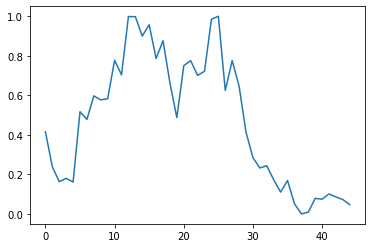

In [ ]:
plt.plot(np.array(Y))

In [ ]:
# Pick three of them 
lm = ols('adjclose ~ OperatingRevenue + BasicEPS  + MarketCap', data=data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     127.6
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           7.96e-21
Time:                        16:26:24   Log-Likelihood:                 39.157
No. Observations:                  45   AIC:                            -70.31
Df Residuals:                      41   BIC:                            -63.09
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0405      0.061     -0.667      0.509      -0.163       0.082
OperatingRevenue  2.543e-11   8.69e-12      2.926      0.006    7.88e-12     4.3e-11
BasicEPS             0.0030      0.006      0.493      0.624      -0.009       0.015
MarketCap         2.365e-11   1.95e-12     12.157      0.000    1.97e-11    2.76e-11
==============================================================================
Omnibus:                        2.223   Durbin-Watson:                   0.541
Prob(Omnibus):                  0.329   Jarque-Bera (JB):                1.725
Skew:                           0.310   Prob(JB):                        0.422
Kurtosis:                       2.268   Cond. No.                     7.21e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.21e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#use efficient columns (VIF less than 20)
X = data[efficient_col] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = data['adjclose']
X = sm.add_constant(X)
est = sm.OLS(Y, X.astype(float)).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     4.241
Date:                Tue, 03 Aug 2021   Prob (F-statistic):            0.00356
Time:                        16:26:24   Log-Likelihood:                -3.6246
No. Observations:                  45   AIC:                             19.25
Df Residuals:                      39   BIC:                             30.09
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1249      0.224      0.557      0.581      -0.329       0.579
BasicEPS       0.0527      0.014      3.707      0.001       0.024       0.081
volume      3.035e-12   8.35e-11      0.036      0.971   -1.66e-10    1.72e-10
PeRatio        0.0287      0.017      1.685      0.100      -0.006       0.063
PegRatio       0.3171      0.307      1.033      0.308      -0.304       0.938
PbRatio       -0.0039      0.004     -0.954      0.346      -0.012       0.004
==============================================================================
Omnibus:                        5.382   Durbin-Watson:                   0.794
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                2.459
Skew:                          -0.272   Prob(JB):                        0.293
Kurtosis:                       1.992   Cond. No.                     5.42e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.42e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
lm = ols('adjclose ~ Inflation + BasicEPS  + MarketCap', data=data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     110.4
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           1.13e-19
Time:                        16:26:27   Log-Likelihood:                 36.239
No. Observations:                  45   AIC:                            -64.48
Df Residuals:                      41   BIC:                            -57.25
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0432      0.055      0.786      0.437      -0.068       0.154
Inflation      0.0354      0.022      1.592      0.119      -0.010       0.080
BasicEPS       0.0088      0.006      1.435      0.159      -0.004       0.021
MarketCap   2.746e-11   1.86e-12     14.770      0.000    2.37e-11    3.12e-11
==============================================================================
Omnibus:                        2.343   Durbin-Watson:                   0.487
Prob(Omnibus):                  0.310   Jarque-Bera (JB):                1.379
Skew:                           0.088   Prob(JB):                        0.502
Kurtosis:                       2.161   Cond. No.                     6.00e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  6e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Regression with LogRetrun
test_data = data[['OperatingRevenue', 'CostOfRevenue', 'OperatingExpense',
'NetNonOperatingInterestIncomeExpense', 
        'TaxProvision','NetIncome',
       'BasicEPS',  'BasicAverageShares', 
       'TotalExpenses', 
       'NormalizedIncome', 'InterestIncome', 'InterestExpense',
       'NetInterestIncome', 'EBIT',  
       'TotalUnusualItems',
        'TaxEffectOfUnusualItems',
        'volume', 'MarketCap',
       'EnterpriseValue', 'PeRatio', 'PegRatio', 'PsRatio',
       'PbRatio','GDP', 'Inflation',
       'ExchangeRate', 'adjclose'
       
    ]]

for i in test_data.columns:
    print(i, '\t', vif(test_data, col_i=i))

# check if there is an zero 
# test_data.all(axis='columns')
test_data.isnull().sum()


OperatingRevenue 	 266.86164780124733
CostOfRevenue 	 inf
OperatingExpense 	 inf
NetNonOperatingInterestIncomeExpense 	 inf
TaxProvision 	 inf
NetIncome 	 inf
BasicEPS 	 20.230187314386608
BasicAverageShares 	 61.547515095387055
TotalExpenses 	 inf
NormalizedIncome 	 inf


<ipython-input-90-6216a0607cca>:8: RuntimeWarning: divide by zero encountered in double_scalars
  return 1. / (1. - r2)


InterestIncome 	 inf
InterestExpense 	 inf
NetInterestIncome 	 inf
EBIT 	 inf
TotalUnusualItems 	 inf
TaxEffectOfUnusualItems 	 inf
volume 	 8.766344655101944
MarketCap 	 292.6419718304297
EnterpriseValue 	 81.71605272889
PeRatio 	 4.740805204263953
PegRatio 	 1.401883936932
PsRatio 	 33.999741238295975
PbRatio 	 1.9700099096759882
GDP 	 68.84085718535434
Inflation 	 4.7005969158490535
ExchangeRate 	 4.9647232615728765
adjclose 	 82.22306985198327


OperatingRevenue                        0
CostOfRevenue                           0
OperatingExpense                        0
NetNonOperatingInterestIncomeExpense    0
TaxProvision                            0
NetIncome                               0
BasicEPS                                0
BasicAverageShares                      0
TotalExpenses                           0
NormalizedIncome                        0
InterestIncome                          0
InterestExpense                         0
NetInterestIncome                       0
EBIT                                    0
TotalUnusualItems                       0
TaxEffectOfUnusualItems                 0
volume                                  0
MarketCap                               0
EnterpriseValue                         0
PeRatio                                 0
PegRatio                                0
PsRatio                                 0
PbRatio                                 0
GDP                               

In [ ]:
X = test_data.iloc[:len(test_data)-1] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = data['log_return'].iloc[:-1]
X = sm.add_constant(X)
est = sm.OLS(Y, X.astype(float)).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     2.077
Date:                Tue, 03 Aug 2021   Prob (F-statistic):             0.0516
Time:                        16:30:43   Log-Likelihood:                 59.833
No. Observations:                  44   AIC:                            -71.67
Df Residuals:                      20   BIC:                            -28.85
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    1.8105      0.973      1.860      0.078      -0.220       3.841
OperatingRevenue                     -3.256e-11   1.13e-10     -0.289      0.775   -2.68e-10    2.02e-10
CostOfRevenue                        -1.835e-05   1.79e-05     -1.026      0.317   -5.57e-05     1.9e-05
OperatingExpense                     -1.835e-05   1.79e-05     -1.026      0.317   -5.57e-05     1.9e-05
NetNonOperatingInterestIncomeExpense  2.111e-07    1.7e-07      1.245      0.228   -1.43e-07    5.65e-07
TaxProvision                          3.856e-07   2.41e-07      1.602      0.125   -1.16e-07    8.88e-07
NetIncome                            -4.422e-07   2.78e-07     -1.592      0.127   -1.02e-06    1.37e-07
BasicEPS                                 0.0196      0.022      0.896      0.381      -0.026       0.065
BasicAverageShares                   -7.421e-10   5.74e-10     -1.294      0.211   -1.94e-09    4.54e-10
TotalExpenses                         1.835e-05   1.79e-05      1.026      0.317    -1.9e-05    5.57e-05
NormalizedIncome                      8.279e-07   5.18e-07      1.597      0.126   -2.54e-07    1.91e-06
InterestIncome                        1.704e-07   1.38e-07      1.232      0.232   -1.18e-07    4.59e-07
InterestExpense                       2.137e-07   1.07e-07      2.003      0.059   -8.85e-09    4.36e-07
NetInterestIncome                    -3.847e-07   3.12e-07     -1.235      0.231   -1.03e-06    2.65e-07
EBIT                                 -3.856e-07   2.41e-07     -1.602      0.125   -8.88e-07    1.17e-07
TotalUnusualItems                     8.275e-07   5.19e-07      1.596      0.126   -2.54e-07    1.91e-06
TaxEffectOfUnusualItems               -8.26e-07   5.19e-07     -1.592      0.127   -1.91e-06    2.56e-07
volume                                4.024e-11   7.46e-11      0.539      0.596   -1.15e-10    1.96e-10
MarketCap                            -5.484e-12   2.46e-11     -0.223      0.826   -5.68e-11    4.58e-11
EnterpriseValue                       2.088e-11   8.55e-12      2.441      0.024    3.04e-12    3.87e-11
PeRatio                                 -0.0080      0.013     -0.622      0.541      -0.035       0.019
PegRatio                                -0.0798      0.117     -0.681      0.504      -0.324       0.164
PsRatio                                 -0.5557      0.315     -1.765      0.093      -1.212       0.101
PbRatio                                  0.0013      0.002      0.737      0.470      -0.002       0.005
GDP                                  -7.232e-05   5.22e-05     -1.384      0.182      -0.000    3.67e-05
Inflation                                0.0284      0.037      0.773      0.449      -0.048       0.105
ExchangeRate                          

In [ ]:
#use efficient columns (VIF less than 20)
X = data[efficient_col].iloc[:len(data)-1] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = data['log_return'].iloc[:-1]
X = sm.add_constant(X)
est = sm.OLS(Y, X.astype(float)).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.7012
Date:                Tue, 03 Aug 2021   Prob (F-statistic):              0.626
Time:                        16:31:39   Log-Likelihood:                 34.927
No. Observations:                  44   AIC:                            -57.85
Df Residuals:                      38   BIC:                            -47.15
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1383      0.094     -1.474      0.149      -0.328       0.052
BasicEPS       0.0016      0.006      0.272      0.787      -0.011       0.014
volume      3.877e-11   3.52e-11      1.103      0.277   -3.24e-11     1.1e-10
PeRatio        0.0106      0.007      1.491      0.144      -0.004       0.025
PegRatio       0.0564      0.128      0.440      0.663      -0.203       0.316
PbRatio        0.0005      0.002      0.270      0.788      -0.003       0.004
==============================================================================
Omnibus:                       19.186   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.902
Skew:                          -1.190   Prob(JB):                     4.35e-08
Kurtosis:                       6.581   Cond. No.                     5.42e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.42e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:

# all factors
test_data = data[['OperatingRevenue', 'CostOfRevenue', 'GrossProfit', 'OperatingExpense',
       'SellingGeneralAndAdministration', 'GeneralAndAdministrativeExpense',
       'SalariesAndWages', 'RentAndLandingFees', 'OtherGandA',
       'SellingAndMarketingExpense',
       'DepreciationAmortizationDepletionIncomeStatement',
       'DepreciationAndAmortizationInIncomeStatement',
       'OtherOperatingExpenses', 'OperatingIncome',
       'NetNonOperatingInterestIncomeExpense', 'InterestIncomeNonOperating',
       'InterestExpenseNonOperating', 'OtherIncomeExpense',
       'SpecialIncomeCharges', 'RestructuringAndMergernAcquisition',
       'ImpairmentOfCapitalAssets', 'OtherSpecialCharges',
       'OtherNonOperatingIncomeExpenses', 'PretaxIncome', 'TaxProvision',
       'NetIncomeCommonStockholders', 'NetIncome',
       'NetIncomeIncludingNoncontrollingInterests',
       'NetIncomeContinuousOperations', 'DilutedNIAvailtoComStockholders',
       'BasicEPS', 'DilutedEPS', 'BasicAverageShares', 'DilutedAverageShares',
       'TotalOperatingIncomeAsReported', 'RentExpenseSupplemental',
       'TotalExpenses', 'NetIncomeFromContinuingAndDiscontinuedOperation',
       'NormalizedIncome', 'InterestIncome', 'InterestExpense',
       'NetInterestIncome', 'EBIT', 'ReconciledCostOfRevenue',
       'ReconciledDepreciation',
       'NetIncomeFromContinuingOperationNetMinorityInterest',
       'TotalUnusualItemsExcludingGoodwill', 'TotalUnusualItems',
       'NormalizedEBITDA', 'TaxRateForCalcs', 'TaxEffectOfUnusualItems',
        'adjclose', 'volume', 'MarketCap',
       'EnterpriseValue', 'PeRatio', 'ForwardPeRatio', 'PegRatio', 'PsRatio',
       'PbRatio', 'EnterprisesValueRevenueRatio',
       'EnterprisesValueEBITDARatio',
]]